In [32]:
#upload local file to colab runtime 
from google.colab import files
uploaded = files.upload()



Saving att-database-of-faces.zip to att-database-of-faces.zip


In [53]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [34]:
%%bash

rm -rf .data
mkdir .data
unzip -q att-database-of-faces.zip -d .data/faces-training
cp -a .data/faces-training .data/faces-test

rm .data/faces-training/*/{1,2,3,4,5}.pgm
rm .data/faces-test/*/{6,7,8,9,10}.pgm


In [54]:
torch.manual_seed(1)

t = tv.transforms.Compose([
    tv.transforms.Grayscale(),
    tv.transforms.ToTensor()
])

# Load AT&T database of faces.
dataset = tv.datasets.ImageFolder(root=".data/faces-training", transform=t)

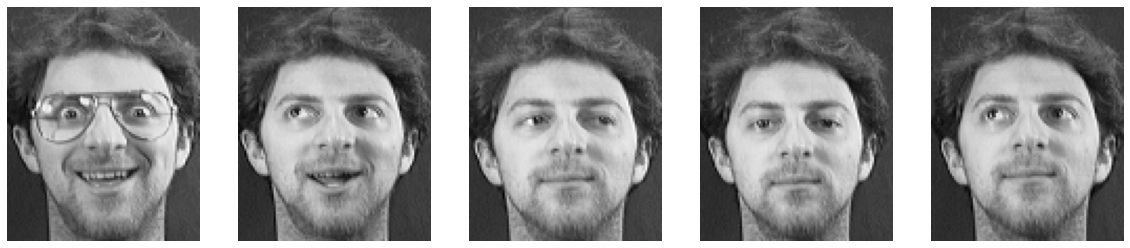

In [55]:
# Specify the person we want to attack
target_person = 37 

all_images_of_target = [img for img, label in dataset if label == target_person]

_, ax = plt.subplots(1, len(all_images_of_target), figsize=(20, 5))
    
for p, img in zip(ax, all_images_of_target):
    p.imshow(img.squeeze(), cmap="gray")
    p.axis("off")

plt.show()

In [56]:
nc = 40
nf = 112 * 92
# linear model classifier
model = torch.nn.Linear(nf, nc)

opt = torch.optim.SGD(model.parameters(), lr=0.1)

criterion = torch.nn.CrossEntropyLoss()


0 30.799955701828004
1 76.71287994384765
2 80.87175331115722
3 82.5915714263916
4 66.73675384521485
5 29.189858055114748
6 30.09798393249512
7 32.186581230163576
8 24.511366271972655
9 14.613455677032471
10 8.470466876029969
11 6.204556787014008
12 1.6670491330325603
13 6.667552833259106
14 5.754139003157616
15 1.003525852318853
16 0.02609298445750028
17 0.003255377654568292
18 0.0009863967803539707
19 0.0008428443659795448


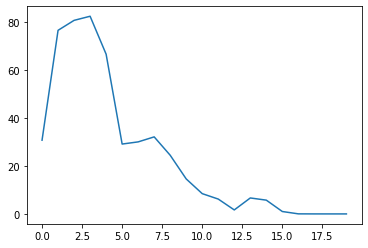

In [57]:
#training process
loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

n_epochs = 20
cost = []

for i in range(n_epochs):
    l = 0
    n = 0
    for img, labels in loader:
        img = img.view(-1, nf)  # from [nbatches, 1, 112, 92] to [nbatches, 10304]
        output = model(img)
        opt.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        
        #########################################################
        # Enable the following lines to get more privacy.
        #########################################################
        #rnd = torch.distributions.normal.Normal(0.0, 1.0)
        #for p in model.parameters():
        #   p.grad += rnd.sample(torch.Size(p.grad.shape)) * 0.3
        #########################################################
        
        opt.step()
        l += loss.item()
        n += 1
    print(i, l/n)
    cost.append(l/n)
        
plt.plot(cost)
plt.show()

In [58]:
#testing model
dataset = tv.datasets.ImageFolder(root=".data/faces-test", transform=t)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=True)
#Disabling gradient calculation  for inference
with torch.no_grad():
    img, labels = iter(test_loader).next()
    r = model(img.view(-1, nf))
    p = r.argmax(dim=1)
    print("images:", len(labels))
    print("accuracy:", (labels == p).sum().item() / len(labels))

images: 200
accuracy: 0.85


In [59]:
#launch model inversion attack
import torch.nn.functional as F

x = torch.zeros(nf, requires_grad=True)
o = torch.optim.SGD([x], lr=0.1)

for i in range(1000):
    scores = F.softmax(model(x.view(1, nf)), dim=1).squeeze()
    e = torch.tensor([1.0]) - scores[target_person] # error for the target label
    o.zero_grad()
    e.backward()
    o.step()
    
x

tensor([-0.0851, -0.0721, -0.0482,  ..., -0.0106, -0.0023, -0.0030],
       requires_grad=True)

In [60]:
r = F.softmax(model(x), dim=0)
print("score of target person:", r[target_person].item())
print("scores:")
r

score of target person: 0.9960254430770874
scores:


tensor([1.3638e-04, 3.2012e-04, 1.4589e-04, 6.3751e-05, 1.8585e-05, 3.6197e-05,
        8.5263e-05, 2.9092e-05, 3.8089e-04, 1.5030e-04, 5.2950e-05, 1.6295e-04,
        1.3641e-04, 9.5583e-05, 2.2431e-05, 3.6286e-04, 1.1732e-04, 1.7183e-06,
        7.1113e-05, 2.3458e-05, 3.6123e-05, 8.0219e-05, 7.8103e-05, 1.4712e-05,
        1.5964e-05, 2.8432e-04, 1.6432e-04, 2.8539e-05, 2.4757e-05, 2.9308e-04,
        5.4880e-05, 1.4860e-04, 3.1058e-05, 8.0526e-06, 5.2692e-05, 1.1064e-05,
        1.1837e-04, 9.9603e-01, 9.6164e-05, 2.0229e-05],
       grad_fn=<SoftmaxBackward>)

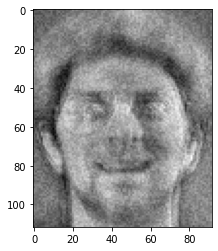

In [61]:
img = x.view(112, 92).detach()

plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
#note：code modified from https://github.com/daniel-e/secml